## Task in Hand 
1. Cleaning the text 
2. Visualizing the number of texts in each class 
3. Building a model to classify the texts 

In [1]:
import pandas as pd 
import numpy
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
import string
import re
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

warnings.filterwarnings('ignore')

In [2]:
# exploring the dataset 

with open("train.csv") as file:
    data_train = pd.read_csv(file)

In [3]:
# printing the info of the dataframe

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
# printing the null values from the dataframe

data_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
# creating a copy of the data 

data = data_train.copy()

## Data Preprocessing and Cleaning

1. Removing all the stop words the from text
2. Removing punctuations the from text
3. Removing hyperlinks the from text

In [6]:
# Removing the stopwords

data["text"] = data["text"].apply(lambda text: " ".join(word for word in str(text).lower().split() if word not in set(stopwords.words('english'))))

data["text"].head()

0        deeds reason #earthquake may allah forgive us
1               forest fire near la ronge sask. canada
2    residents asked 'shelter place' notified offic...
3    13,000 people receive #wildfires evacuation or...
4    got sent photo ruby #alaska smoke #wildfires p...
Name: text, dtype: object

In [7]:
# removing http links from the data 

data["text"] = data["text"].apply(lambda text: re.sub('((www.[^s]+)|(https?://[^s]+))','',str(text)))
data["text"].head()

0        deeds reason #earthquake may allah forgive us
1               forest fire near la ronge sask. canada
2    residents asked 'shelter place' notified offic...
3    13,000 people receive #wildfires evacuation or...
4    got sent photo ruby #alaska smoke #wildfires p...
Name: text, dtype: object

In [8]:
# removing all the special charactres  

data["text"] = data["text"].apply(lambda text: text.translate(str.maketrans('','',string.punctuation)))

data["text"].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive wildfires evacuation orde...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

## Visualizing the target variables 

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

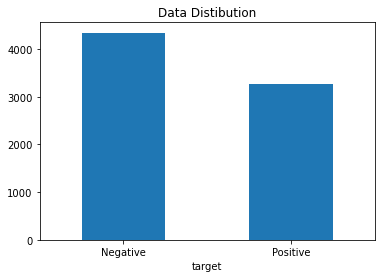

In [9]:
data_text = data.drop(["id","keyword","location"],axis=1) # visualizing only the text column and dropping the rest

ax = data_text.groupby("target").count().plot(kind="bar",title="Data Distibution",legend=False)
ax.set_xticklabels(["Negative","Positive"],rotation=0)

In [10]:
positive_cases = data[data["target"] == 1]
negative_cases = data[data["target"] == 0]

f"Positive Cases - {len(positive_cases)} and Negative Cases - {len(negative_cases)}"

'Positive Cases - 3271 and Negative Cases - 4342'

### using ngrams to find frequent phrases in positive and negative classes 

In [11]:
Stopwords = set(stopwords.words('english'))

positive_ngrams = [val for text in positive_cases["text"].tolist() for val in ngrams(text.split(),2)]

common_in_positive = Counter(positive_ngrams)

common_in_positive.most_common(20)

[(('suicide', 'bomber'), 59),
 (('northern', 'california'), 41),
 (('oil', 'spill'), 38),
 (('burning', 'buildings'), 35),
 (('suicide', 'bombing'), 34),
 (('california', 'wildfire'), 34),
 (('70', 'years'), 30),
 (('bomber', 'detonated'), 30),
 (('confirmed', 'mh370'), 29),
 (('homes', 'razed'), 29),
 (('razed', 'northern'), 28),
 (('16yr', 'old'), 28),
 (('pkk', 'suicide'), 28),
 (('detonated', 'bomb'), 28),
 (('severe', 'thunderstorm'), 27),
 (('mass', 'murder'), 27),
 (('latest', 'homes'), 27),
 (('old', 'pkk'), 27),
 (('debris', 'found'), 26),
 (('mh370', 'malaysia'), 26)]

In [12]:
negative_ngrams = [val for text in negative_cases["text"].tolist() for val in ngrams(text.split(),2)]

common_in_negative = Counter(negative_ngrams)

common_in_negative.most_common(10)

[(('cross', 'body'), 38),
 (('youtube', 'video'), 36),
 (('liked', 'youtube'), 35),
 (('body', 'bag'), 26),
 (('full', 're\x89û'), 25),
 (('body', 'bagging'), 23),
 (('burning', 'buildings'), 23),
 (('full', 'read'), 22),
 (('looks', 'like'), 21),
 (('reddit', 'quarantine'), 21)]

## Visualizing bigrams 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

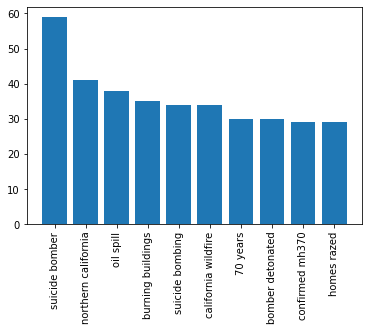

In [13]:
scores = common_in_positive.most_common(10)

score = list()
n_grams = list()
for names,scores in scores:
    score.append(scores)
    n_grams.append(" ".join(names))

X_axis = numpy.arange(len(n_grams))

plt.bar(n_grams,score)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

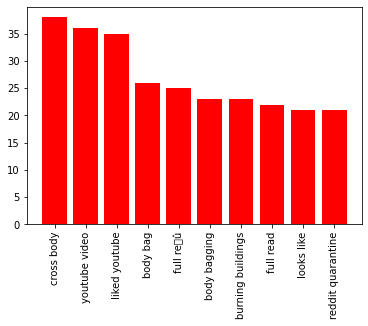

In [14]:
scores = common_in_negative.most_common(10)

score = list()
n_grams = list()
for names,scores in scores:
    score.append(scores)
    n_grams.append(" ".join(names))

X_axis = numpy.arange(len(n_grams))

plt.bar(n_grams,score,color="red")
plt.xticks(rotation=90)

### Will Start building a model from here

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

X = vectorizer.fit_transform(data["text"])
y = data["target"]

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.33,stratify=y)


In [17]:
model = LinearSVC(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

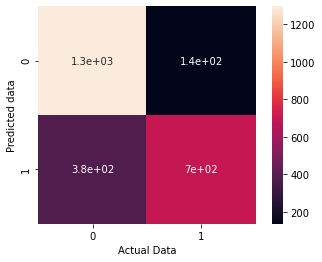

In [18]:
# printing the confusion metrix 

matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(matrix,annot=True,square=True)
plt.xlabel("Actual Data")
plt.ylabel("Predicted data")
plt.show()

In [19]:
score_precision = precision_score(y_test,y_pred)
score_recall = recall_score(y_test,y_pred)

f"Precision Score - {score_precision} & recall score {score_recall}"

'Precision Score - 0.8365155131264916 & recall score 0.649074074074074'

In [20]:
# the f1_Score 

score_f1 = f1_score(y_test,y_pred)
score_f1

0.7309697601668405

In [21]:
# priting classification 

report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1433
           1       0.84      0.65      0.73      1080

    accuracy                           0.79      2513
   macro avg       0.81      0.78      0.78      2513
weighted avg       0.80      0.79      0.79      2513



In [22]:
# priting the accuracy matrix
accuracy = accuracy_score(y_test,y_pred)

f"Accuracy Score - {accuracy}"

'Accuracy Score - 0.7946677278153601'